# Análisis de eficacia de CallMeBaby
**Objetivo:** Realizar un análisis sobre la eficacia de los operadores de un servicio de telefonía virtual.

**Métricas empleadas:**

Para <span style="color: gold;">**definir la eficacia/ineficacia**</span> de los operadores se considera: un gran número de llamadas entrantes perdidas (internas y externas),tiempo de espera prolongado en llamadas entrantes y bajo número de llamadas salientes.

Por lo que se emplearán las siguientes métricas:
* Velocidad media de respuesta (ASA)
* Tasa de llegada de llamadas
* Volumen de llamadas salientes

**Etapas**
* EDA
* Identificar operadores ineficaces
* Prueba de hipótesis

## Diccionario de datos
`telecom_dataset_us.csv` contiene las siguientes columnas:
- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

`telecom_clients_us.csv` tiene las siguientes columnas:
- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

In [1]:
# importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.stats.multitest import multipletests

In [2]:
# definir estilo de gráficos
plt.style.use('dark_background')

In [3]:
# importar datasets
calls = pd.read_csv('telecom_dataset_new.csv')
clients = pd.read_csv('telecom_clients.csv')

# EDA

In [4]:
# información sobre "calls"
calls.info()
print('\n', 'Datos duplicados:', calls.duplicated().sum())
print('\n', calls.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

 Datos duplicados: 4900

        user_id                       date direction internal  operator_id  \
42765   167977  2019-10-24 00:00:00+03:00        in    False     944220.0   
10697   166678  2019-11-24 00:00:00+03:00        in    False     900892.0   
44125   16802

In [5]:
# información sobre "clients"
clients.info()
print('\n', 'Datos duplicados:', clients.duplicated().sum())
print('\n', 'Total de clientes:', clients['user_id'].nunique())
print('\n', clients.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB

 Datos duplicados: 0

 Total de clientes: 732

      user_id tariff_plan  date_start
408   166655           C  2019-08-13
695   166530           B  2019-08-07
29    167810           A  2019-10-01
187   168228           C  2019-10-17
342   167014           C  2019-08-28


### Comentario
En el DataFrame de "calls" se encontró valores ausentes y 4,900 duplicados, además, hay que realizar una transformación de tipo de datos. Por otro lado en el DataFrame de "clients" también hay que realizar una transformación de tipo de datos.

In [6]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


## Procesamiento de datos

In [7]:
# procesamiento en "calls" y "clients"
# calls
# transformación de tipo de datos
calls['user_id'] = calls['user_id'].astype('str')
calls['date'] = pd.to_datetime(calls['date'])
calls['is_missed_call'] = calls['is_missed_call'].astype('str')
# manejo de valores ausentes 
calls['operator_id'] = calls['operator_id'].fillna(999).astype('int')              # rellenar nulos con "999" y convertir a int
calls['operator_id'] = calls['operator_id'].astype('str').replace('999', 'unknow') # convertir a str y remplazar por "unknow"
calls = calls.dropna()                                                             # se borraron los ausentes (117) en columna "internal" 
# manejo de duplicados
calls = calls.drop_duplicates()

# clients
# transformación de tipo de datos
clients['user_id'] = clients['user_id'].astype('str')
clients['date_start'] = pd.to_datetime(clients['date_start'])

In [8]:
# ordenar por fecha
calls = calls.sort_values(by='date')

### Comentario
Los valores nulos en ``"operator_id"`` fueron reemplazados con la etiqueta "unknow".

## Análisis de métricas de desempeño

In [9]:
# agregar tiempo de espera de la llamada
calls['waiting_time'] = calls['total_call_duration'] - calls['call_duration']
# agregar día
calls['dt'] = calls['date'].dt.date
# agregar plan de tarifa a cada cliente
calls = calls.merge(clients[['user_id', 'tariff_plan']], on='user_id', how='left')

In [10]:
print('Start of period:', calls['date'].min())
print('End of period:', calls['date'].max())

Start of period: 2019-08-02 00:00:00+03:00
End of period: 2019-11-28 00:00:00+03:00


Total calls in period: 806484


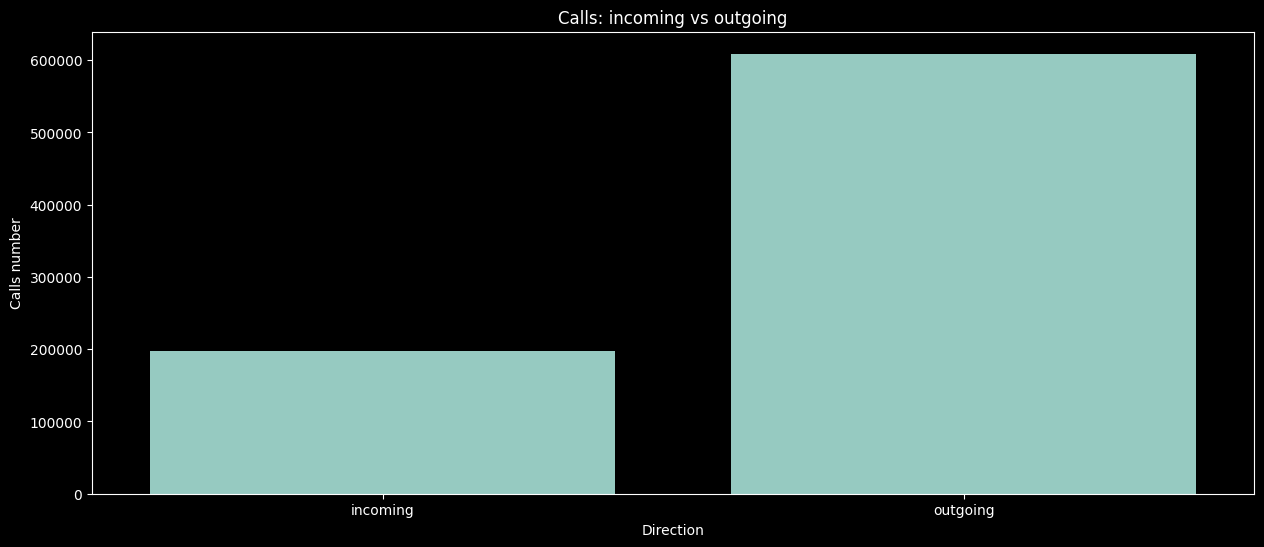

In [11]:
# número de llamadas entrantes vs salientes
# agrupar por dirección de la llamada
direction_calls = (
    calls.groupby('direction', as_index=False)
    .agg({'calls_count':'sum'})
)

direction_calls['direction'] = direction_calls['direction'].replace({'in':'incoming', 'out':'outgoing'})

print('Total calls in period:',direction_calls['calls_count'].sum())

# gráfico de barras: llamadas entrantes vs salientes
plt.figure(figsize=[15,6])
sns.barplot(direction_calls,
            x='direction',
            y='calls_count')
plt.title('Calls: incoming vs outgoing')
plt.ylabel('Calls number')
plt.xlabel('Direction')
plt.show()

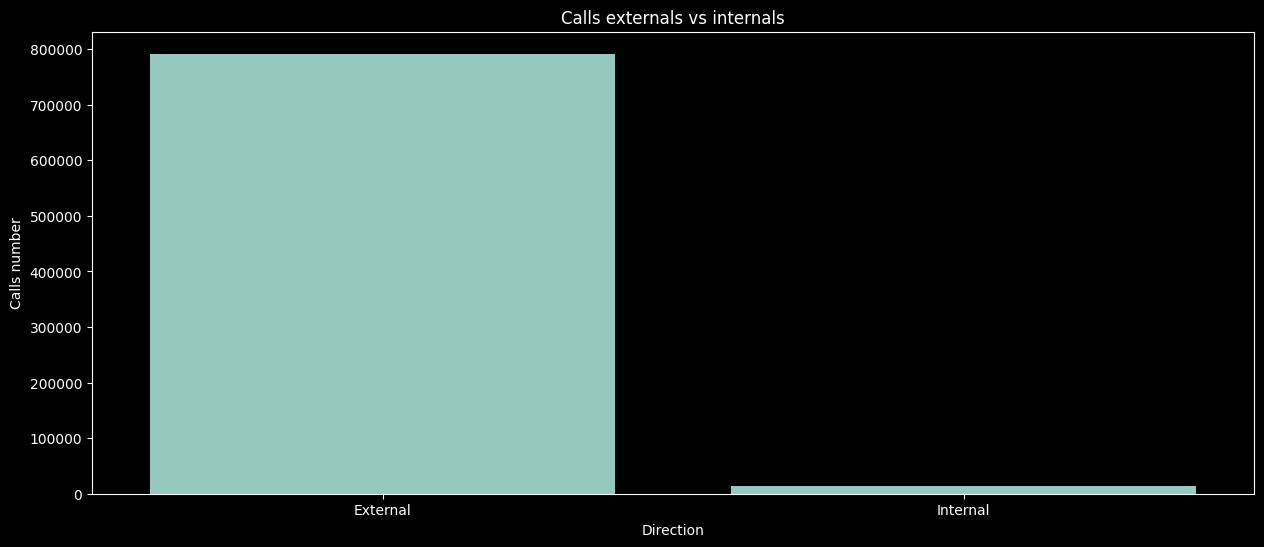

In [12]:
# número de llamadas externas vs internas
# agrupar por dirección de la llamada
internal_calls = (
    calls.groupby('internal', as_index=False)
    .agg({'calls_count':'sum'})
)

internal_calls['internal'] = internal_calls['internal'].replace({False: 'External', True:'Internal'})

# gráfico de barras: llamadas externas vs internas
plt.figure(figsize=[15,6])
sns.barplot(internal_calls,
            x='internal',
            y='calls_count')
plt.title('Calls externals vs internals')
plt.ylabel('Calls number')
plt.xlabel('Direction')
plt.show()


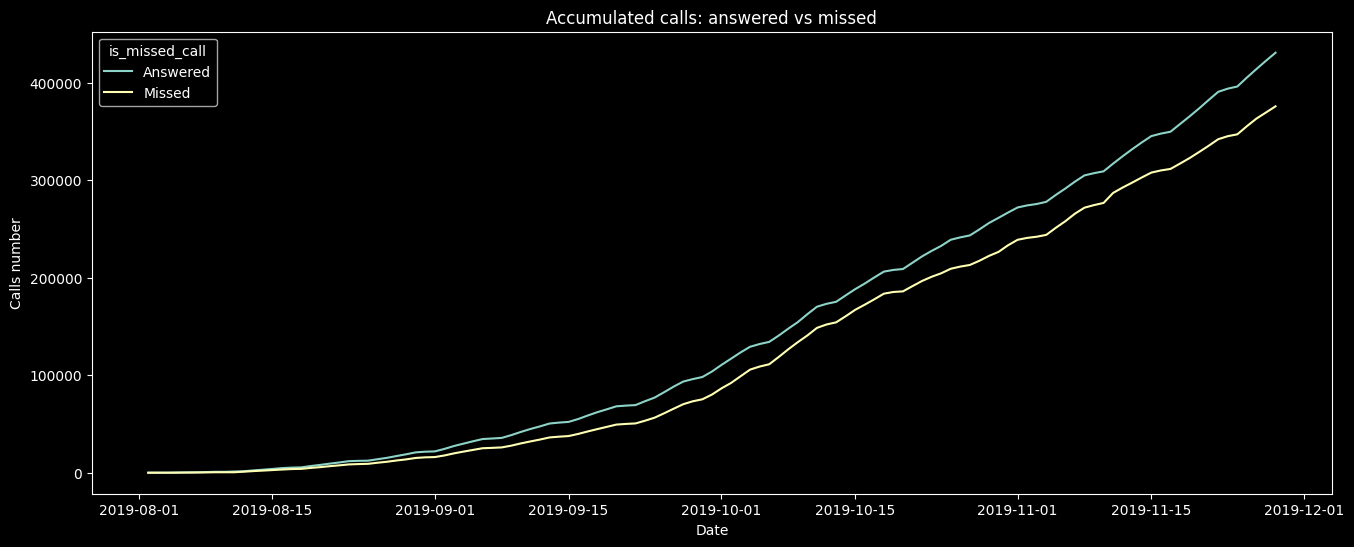

In [13]:
# acumulado de llamadas atendidas y no atendidas
accumulated_calls = (
    calls.groupby(['dt', 'is_missed_call'], as_index=False)
    .agg({'calls_count':'sum'})
)

accumulated_calls['is_missed_call'] = accumulated_calls['is_missed_call'].replace({'False':'Answered', 'True':'Missed'})
accumulated_calls['calls_cumulative'] = accumulated_calls.groupby('is_missed_call')['calls_count'].transform('cumsum')

# gráfico de líneas: acumulado de llamadas atendidas y no atendidas
plt.figure(figsize=[16,6])
sns.lineplot(accumulated_calls,
             x='dt',
             y='calls_cumulative',
             hue='is_missed_call')
plt.title('Accumulated calls: answered vs missed')
plt.ylabel('Calls number')
plt.xlabel('Date')
plt.show()
plt.show()

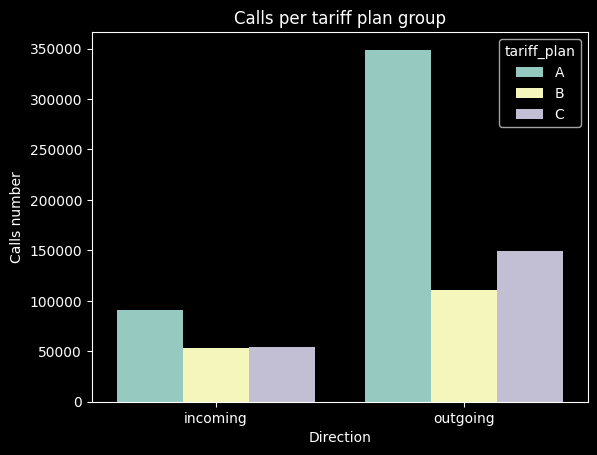

In [14]:
# número de llamadas por usuarios de cada plan
# agrupar por tipo de llamada
calls_per_tariffplan = (
    calls.groupby(['tariff_plan', 'direction'], as_index=False)
    .agg({'calls_count':'sum'})
)

calls_per_tariffplan['direction'] = calls_per_tariffplan['direction'].replace({'in':'incoming', 'out':'outgoing'})

# gráfico de barras: llamadas por usuarios de cada plan
sns.barplot(calls_per_tariffplan,
            x='direction',
            y='calls_count',
            hue='tariff_plan')
plt.title('Calls per tariff plan group')
plt.ylabel('Calls number')
plt.xlabel('Direction')
plt.show()

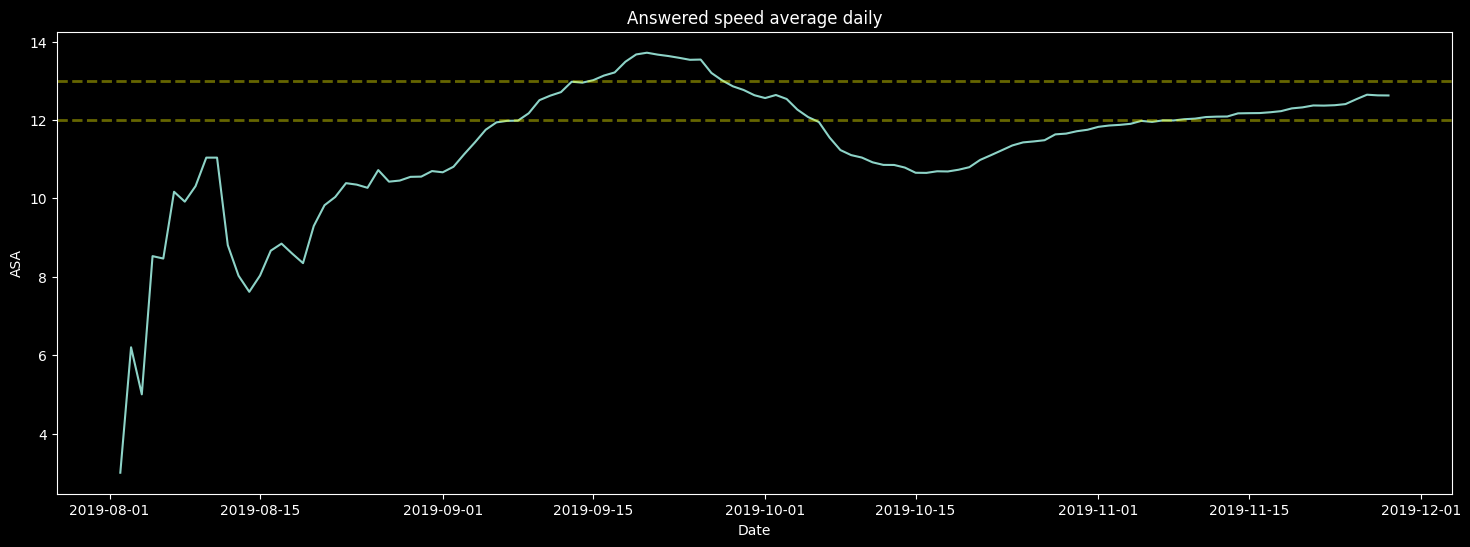

In [15]:
# velocidad media de respuesta (ASA)
# filtrar por llamadas entrantes
incoming_calls = calls.query('direction == "in"')

# calcular ASA (total waiting time / calls number)
ASA = (
    incoming_calls.groupby('dt', as_index=False)
    .agg({
        'calls_count':'sum',
        'waiting_time':'sum'
    })
)

ASA['total_calls'] = ASA['calls_count'].cumsum()
ASA['total_waiting_time'] = ASA['waiting_time'].cumsum()
ASA['asa'] = ASA['total_waiting_time'] / ASA['total_calls']

# gráfico de líneas: ASA por día
plt.figure(figsize=[18,6])

sns.lineplot(ASA,
            x='dt',
            y='asa')
plt.title('Answered speed average daily')
plt.ylabel('ASA')
plt.xlabel('Date')
plt.axhline(y=13, color='yellow', linestyle='--', linewidth=2, alpha=0.4)
plt.axhline(y=12, color='yellow', linestyle='--', linewidth=2, alpha=0.4)
plt.show()

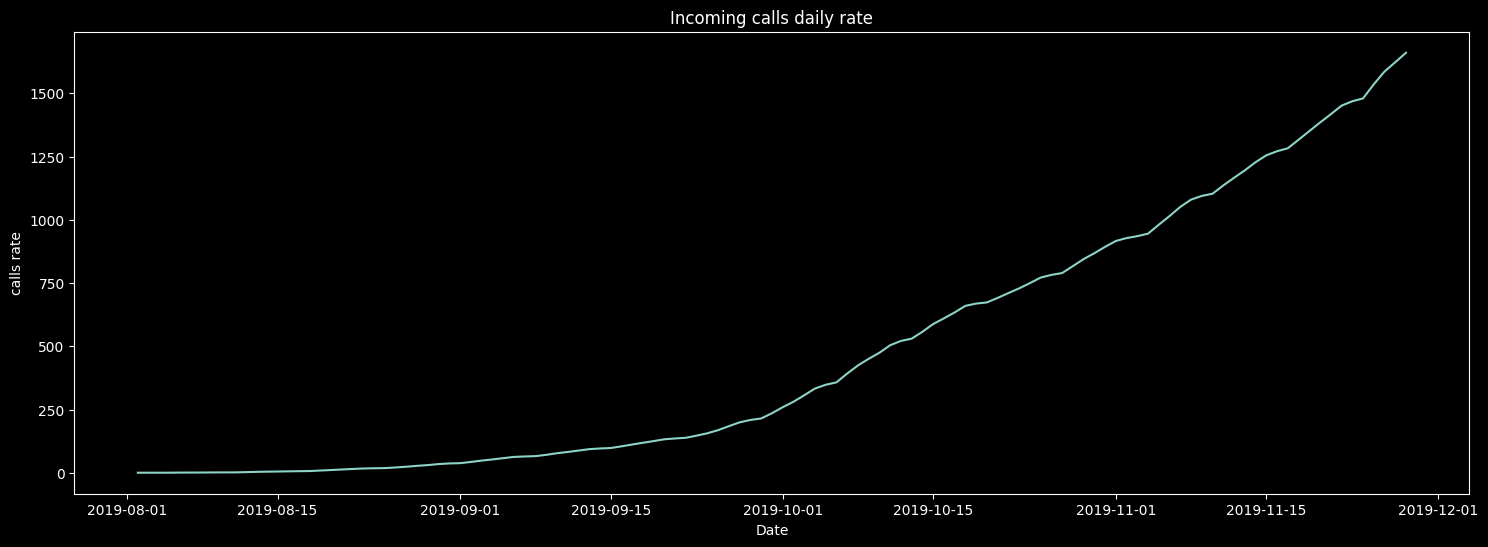

In [16]:
# tasa de llegada de llamadas
# calcular tasa de llegada de llamadas (daily calls / total calls)
incoming_calls_rate = (
    incoming_calls.groupby('dt', as_index=False)
    .agg({'calls_count':'sum'})
)

incoming_calls_rate['total_calls'] = incoming_calls_rate['calls_count'].cumsum()
incoming_calls_rate['calls_rate'] = incoming_calls_rate['total_calls'] / len(incoming_calls_rate)

# gráfico de líneas: tasa diaria de llegada de llamadas
plt.figure(figsize=[18,6])

sns.lineplot(incoming_calls_rate,
             x='dt',
             y='calls_rate')
plt.title('Incoming calls daily rate')
plt.ylabel('calls rate')
plt.xlabel('Date')
plt.show()

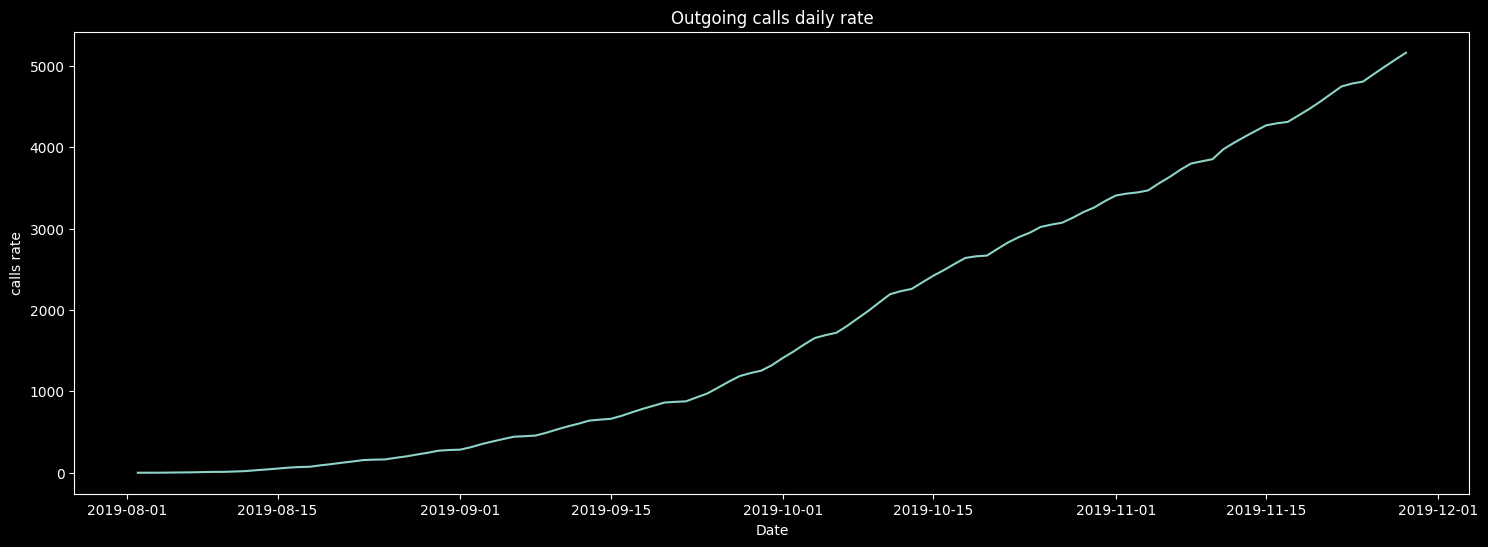

In [17]:
# volumen de llamadas salientes
# filtrar por llamadas salientes
outgoing_calls = calls.query('direction == "out"')

# calcular tasa de llegada de llamadas (daily calls / total calls)
outgoing_calls_rate = (
    outgoing_calls.groupby('dt', as_index=False)
    .agg({'calls_count':'sum'})
)

outgoing_calls_rate['total_calls'] = outgoing_calls_rate['calls_count'].cumsum()
outgoing_calls_rate['calls_rate'] = outgoing_calls_rate['total_calls'] / len(outgoing_calls_rate)

# gráfico de líneas: tasa diaria de llegada de llamadas
plt.figure(figsize=[18,6])

sns.lineplot(outgoing_calls_rate,
             x='dt',
             y='calls_rate')
plt.title('Outgoing calls daily rate')
plt.ylabel('calls rate')
plt.xlabel('Date')
plt.show()

In [18]:
missed_calls = calls.query('is_missed_call == "True" and call_duration != 0')
missed_calls

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,dt,tariff_plan
164,166503,2019-08-12 00:00:00+03:00,in,True,884408,True,1,38,69,31,2019-08-12,B
213,166582,2019-08-13 00:00:00+03:00,in,False,885890,True,1,1,9,8,2019-08-13,A
505,166677,2019-08-19 00:00:00+03:00,in,False,890618,True,1,1,2,1,2019-08-19,C
567,166582,2019-08-20 00:00:00+03:00,in,False,885876,True,1,1,7,6,2019-08-20,A
1246,166582,2019-08-27 00:00:00+03:00,in,False,885890,True,1,1,6,5,2019-08-27,A
...,...,...,...,...,...,...,...,...,...,...,...,...
48217,167264,2019-11-28 00:00:00+03:00,in,False,919554,True,1,20,64,44,2019-11-28,B
48275,168062,2019-11-28 00:00:00+03:00,in,False,951508,True,1,72,99,27,2019-11-28,A
48396,168252,2019-11-28 00:00:00+03:00,in,False,940588,True,1,135,148,13,2019-11-28,A
48404,168252,2019-11-28 00:00:00+03:00,in,False,940652,True,1,84,87,3,2019-11-28,A


In [19]:
# operadores desconicdos
operators_unknow = calls.query('operator_id == "unknow"')
print('Llamadas de operadores desconocidos:',operators_unknow['calls_count'].sum())

Llamadas de operadores desconocidos: 104399


### Comentario
De manera general, durante el periodo del 2-Oct al 28-Nov del 2029, se registró un total de 806,484 llamadas de las cuales la mayoría fueron salientes y menos del 2% fueron llamadas internas. Del total de llamadas casi la mitad fueron perdidas (no se contestaron). Con respecto a los planes de tarifa de los clientes, se hicieron y recibieron más llamadas para los clientes "A".

Se encontró que hay llamadas etiquetadas como "missed" pero tienen duración, esto puede deberse a algún sistema de grabación de recado o a un mal etiquetado, sin embargo, hasta verificar la razón de esto se van a mantener para los análisis.

En cuanto a las métricas de rendimiento: la <span style="color: gold;">**velocidad de respuesta de llamada**</span> terminó entorno a los <span style="color: gold;">**12 segundos**</span>, la <span style="color: gold;">**tasa de llamadas diarias entrantes es de 1,600**</span> y la <span style="color: gold;">**tasa de llamadas salientes es de 5,159**</span>.

Para el análisis de los operadores ineficaces <span style="color: gold;">**no se tomaran en cuenta los registros de operadores desconocidos**</span>.

# Identificar operadores ineficaces

In [20]:
# identificar número de operadores
# filtrar los operadores desconocidos
call_analysis = calls[calls['operator_id'] != 'unknow']

# número de operadores
operators = call_analysis['operator_id'].unique().tolist()
print(f'Hay {len(operators)} operadores')

Hay 1092 operadores


## Analizar métricas de llamadas por operador

       calls_count
count   753.000000
mean      4.690583
std      10.625789
min       1.000000
25%       1.200000
50%       1.800000
75%       3.521739
max     141.280000


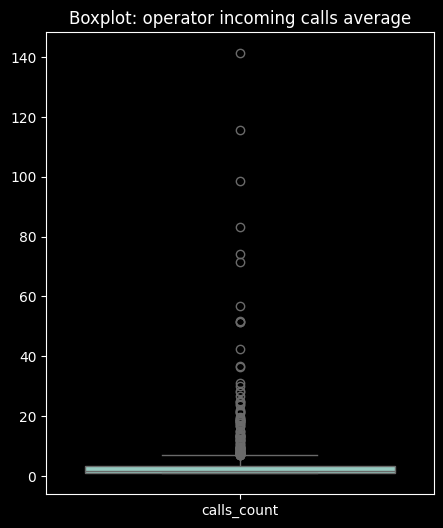

In [21]:
# promedio de llamadas atendidas por operador
# filtrar llamadas atendidas
operators_answered_calls = call_analysis.query('direction == "in" and is_missed_call == "False"')
# promedio de llamadas
avg_answered_calls = (
    operators_answered_calls.groupby('operator_id', as_index=False)
    .agg({'calls_count':'mean'}) 
)

# mostrar datos descriptivos
print(avg_answered_calls.describe())

# boxplot: promedio de llamadas atendidas por operador
plt.figure(figsize=[5,6])

sns.boxplot(avg_answered_calls)
plt.title('Boxplot: operator incoming calls average')
plt.show()

              asa
count  754.000000
mean    17.686279
std     12.282207
min      0.672117
25%      9.427976
50%     14.412037
75%     22.468750
max    115.500000


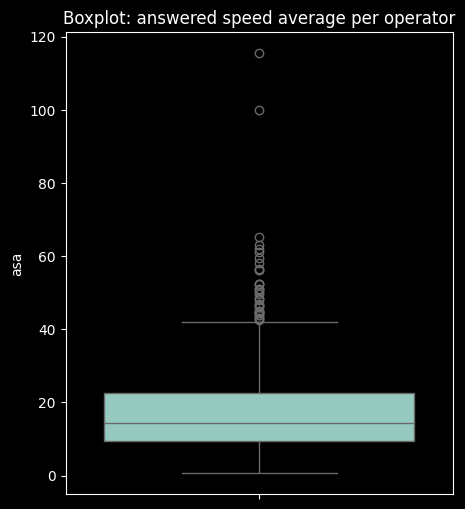

In [22]:
# velocidad media de respuesta (ASA) promedio por operador
# filtrar llamadas entrantes sin operadores desconocidos
incoming_calls = incoming_calls.query('operator_id != "unknow"')

# calcular ASA diario por operador
ASA_operators = (
    incoming_calls.groupby(['operator_id', 'dt'], as_index=False)
    .agg({
        'waiting_time':'sum',
        'calls_count':'sum'
    })
)
ASA_operators['asa'] = ASA_operators['waiting_time'] / ASA_operators['calls_count']

# calcular ASA promedio por operador
avg_asa_operators = (
    ASA_operators.groupby('operator_id', as_index=False)
    .agg({'asa':'mean'})
)

# mostrar datos descriptivos
print(avg_asa_operators.describe())

# boxplot: promedio de llamadas diarias atendidas por operador
plt.figure(figsize=[5,6])

sns.boxplot(avg_asa_operators['asa'])
plt.title('Boxplot: answered speed average per operator')
plt.show()

       calls_count
count   882.000000
mean     14.651573
std      33.040537
min       1.000000
25%       2.000000
50%       3.656863
75%      13.480139
max     426.152174


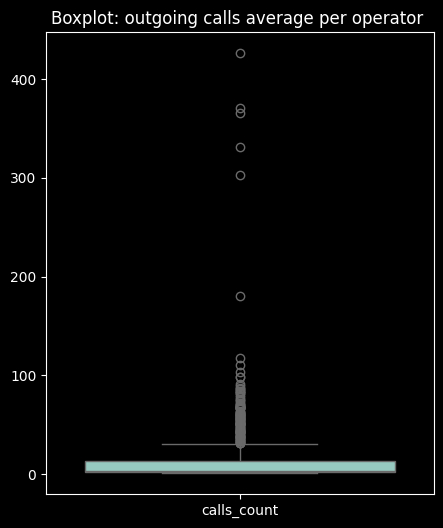

In [23]:
# promedio de llamadas salientes por operador
# filtrar llamadas salientes sin operadores desconocidos
outgoing_calls = outgoing_calls.query('operator_id != "unknow"')

# promedio de llamadas
avg_outgoing_calls = (
    outgoing_calls.groupby('operator_id', as_index=False)
    .agg({'calls_count':'mean'}) 
)

# mostrar datos descriptivos
print(avg_outgoing_calls.describe())

# boxplot: promedio de llamadas realizadas por operador
plt.figure(figsize=[5,6])

sns.boxplot(avg_outgoing_calls)
plt.title('Boxplot: outgoing calls average per operator ')
plt.show()

## Definir operadores ineficaces
Para definir a los operadores ineficaces se tomará en cuenta los datos generales de las métricas y se dividirán entre el número de operadores, de esta forma se haría un estimado de la cantidad de llamadas y tiempo de espera correspondido a cada operador.

**Datos de métricas generales:**
* ASA = 15 segundos diarios
* Llamadas entrantes = 1,600 diarias
* Llamadas salientes = 5,159 diarias

Total de operadores = 1,092

In [24]:
print('Cada operador debería de atender por lo menos:',1600 / 1092, 'llamada(s) diaria(s)')
print('Cada operador debería de realizar por lo menos:',5159 / 1092, 'llamada(s) diaria(s)')

Cada operador debería de atender por lo menos: 1.465201465201465 llamada(s) diaria(s)
Cada operador debería de realizar por lo menos: 4.7243589743589745 llamada(s) diaria(s)


In [25]:
# crear DataFrame de métricas por operador
operators_info = pd.merge(avg_outgoing_calls, avg_asa_operators, how='outer', on='operator_id')
operators_info = operators_info.merge(avg_answered_calls, how='outer', on='operator_id')

# renombrar columnas
operators_info.rename(columns={'calls_count_x':'outgoing_calls', 'calls_count_y':'answered_calls'}, inplace=True)

# rellenar ausentes con "0"
operators_info = operators_info.fillna(0)

In [26]:
# definir operadores ineficaces
inefficient_operators = operators_info[
    (operators_info['answered_calls'] < 1) |   # menos de 1 llamada atendida
    (operators_info['asa'] > 15) |             # más de 15 segundos promedio de tiempo de espera
    (operators_info['outgoing_calls'] < 5)     # menos de 5 llamadas realizadas
]

inefficient_operators


,operator_id,outgoing_calls,asa,answered_calls
2,880020,2.923077,7.714286,1.0
3,880022,3.048387,14.000000,1.0
6,880240,3.916667,0.000000,0.0
7,881278,2.500000,0.000000,0.0
8,882476,0.000000,31.666667,1.0
...,...,...,...,...
1086,972408,3.000000,0.000000,0.0
1087,972410,19.250000,0.000000,0.0
1088,972412,15.000000,25.000000,1.0
1090,973120,1.500000,0.000000,0.0


In [27]:
# definir operadores eficaces
efficient_operators = operators_info[~operators_info['operator_id'].isin(inefficient_operators['operator_id'])]

efficient_operators

,operator_id,outgoing_calls,asa,answered_calls
0,879896,9.083333,13.396199,2.761905
1,879898,42.405882,14.206548,1.839286
4,880026,13.463415,5.935185,1.333333
5,880028,15.509317,6.106504,1.536585
17,883940,20.387097,11.800000,1.200000
...,...,...,...,...
1043,964510,6.894737,11.296667,2.600000
1045,964666,62.615385,12.820734,5.714286
1059,968150,7.583333,1.000000,2.000000
1061,968338,16.384615,9.388889,2.166667


### Comentario
Finalmente se consideró como operadores ineficaces aquellos que tuvieran:
* menos de 1 llamada atendida
* más de 15 segundos promedio de tiempo de espera
* menos de 5 llamadas realizadas

Teniendo <span style="color: gold;">**950 operadores ineficaces y 130 eficaces**</span>.

# Prueba de hipótesis
Se pretende realizar la comparación entre las métricas de los operadores eficaces vs ineficaces para confirmar si hay diferencia entre ellos.

### Hipótesis 1: Llamadas realizadas
``**H0**`` = NO hay diferencia en las llamadas realizadas entre los operadores eficaces e ineficaces
``**H1**`` = Hay diferencia en las llamadas realizadas entre los operadores eficaces e ineficaces

### Hipótesis 2: Tiempo de espera
``**H0**`` = NO hay diferencia en el tiempo de espera entre los operadores eficaces e ineficaces
``**H1**`` = Hay diferencia en el tiempo de espera entre los operadores eficaces e ineficaces

### Hipótesis 3: Llamadas atendidas
``**H0**`` = NO hay diferencia en las llamadas atendidas entre los operadores eficaces e ineficaces
``**H1**`` = Hay diferencia en las llamadas atendidas entre los operadores eficaces e ineficaces

Para esta comprobar las hipótesis se empleará la prueba estadística ``**Mann–Whitney**`` junto con el método ``**"Holm"**`` para el ajuste de ``FWER``. El alpha se define en 0.5 para mantener un buen nivel de confiabilidad.

In [28]:
# función para prueba de hipótesis
def hypothesis_test (variable):
    '''
    Esta función toma 2 grupos (operadores eficientes e ineficientes)
    aplica la prueba U-MannWhitney a la variable elegida y devuelve el valor "p"
    '''
    #==============================formar grupos==============================
    group_A = efficient_operators[variable]
    group_B = inefficient_operators[variable]

    #==========================test U-MannWhitney=============================
    u_test = st.mannwhitneyu(group_A, group_B, alternative='two-sided')
    
    #==========================devolver valor "p"=============================
    return u_test.pvalue

In [29]:
# prueba de hipótesis
# obtener valores "p" de cada hipótesis
hypothesis_1 = hypothesis_test('outgoing_calls')
hypothesis_2 = hypothesis_test('asa')
hypothesis_3 = hypothesis_test('answered_calls')

# ajuste de FWER (tasa de error por familia)
# valores 'p' de los test
p_vals = [hypothesis_1, hypothesis_2, hypothesis_3]

# definir alpha
alpha = 0.05

# método Holm-Bonferroni
reject, p_vals_corr, _, _ = multipletests(p_vals, alpha=alpha, method='holm')

# mostrar resultados de las hipótesis
for index, p_val in enumerate(p_vals_corr):
    if reject[index]:
        print(f'p_value ajustado: {p_val:.5f} → diferencia significativa (rechazar H0)')
    else:
        print(f'p_value ajustado: {p_val:.5f} → NO significativa (no rechazar H0)')

print(reject)

p_value ajustado: 0.00000 → diferencia significativa (rechazar H0)
p_value ajustado: 0.35866 → NO significativa (no rechazar H0)
p_value ajustado: 0.00000 → diferencia significativa (rechazar H0)
[ True False  True]
